In [1]:
%run -i ~/code/mTOMO/common.py

In [2]:
import os
import glob,linecache,shutil
import numpy as np
import xarray as xr

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
here = os.getcwd()

In [5]:
here

'/Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components'

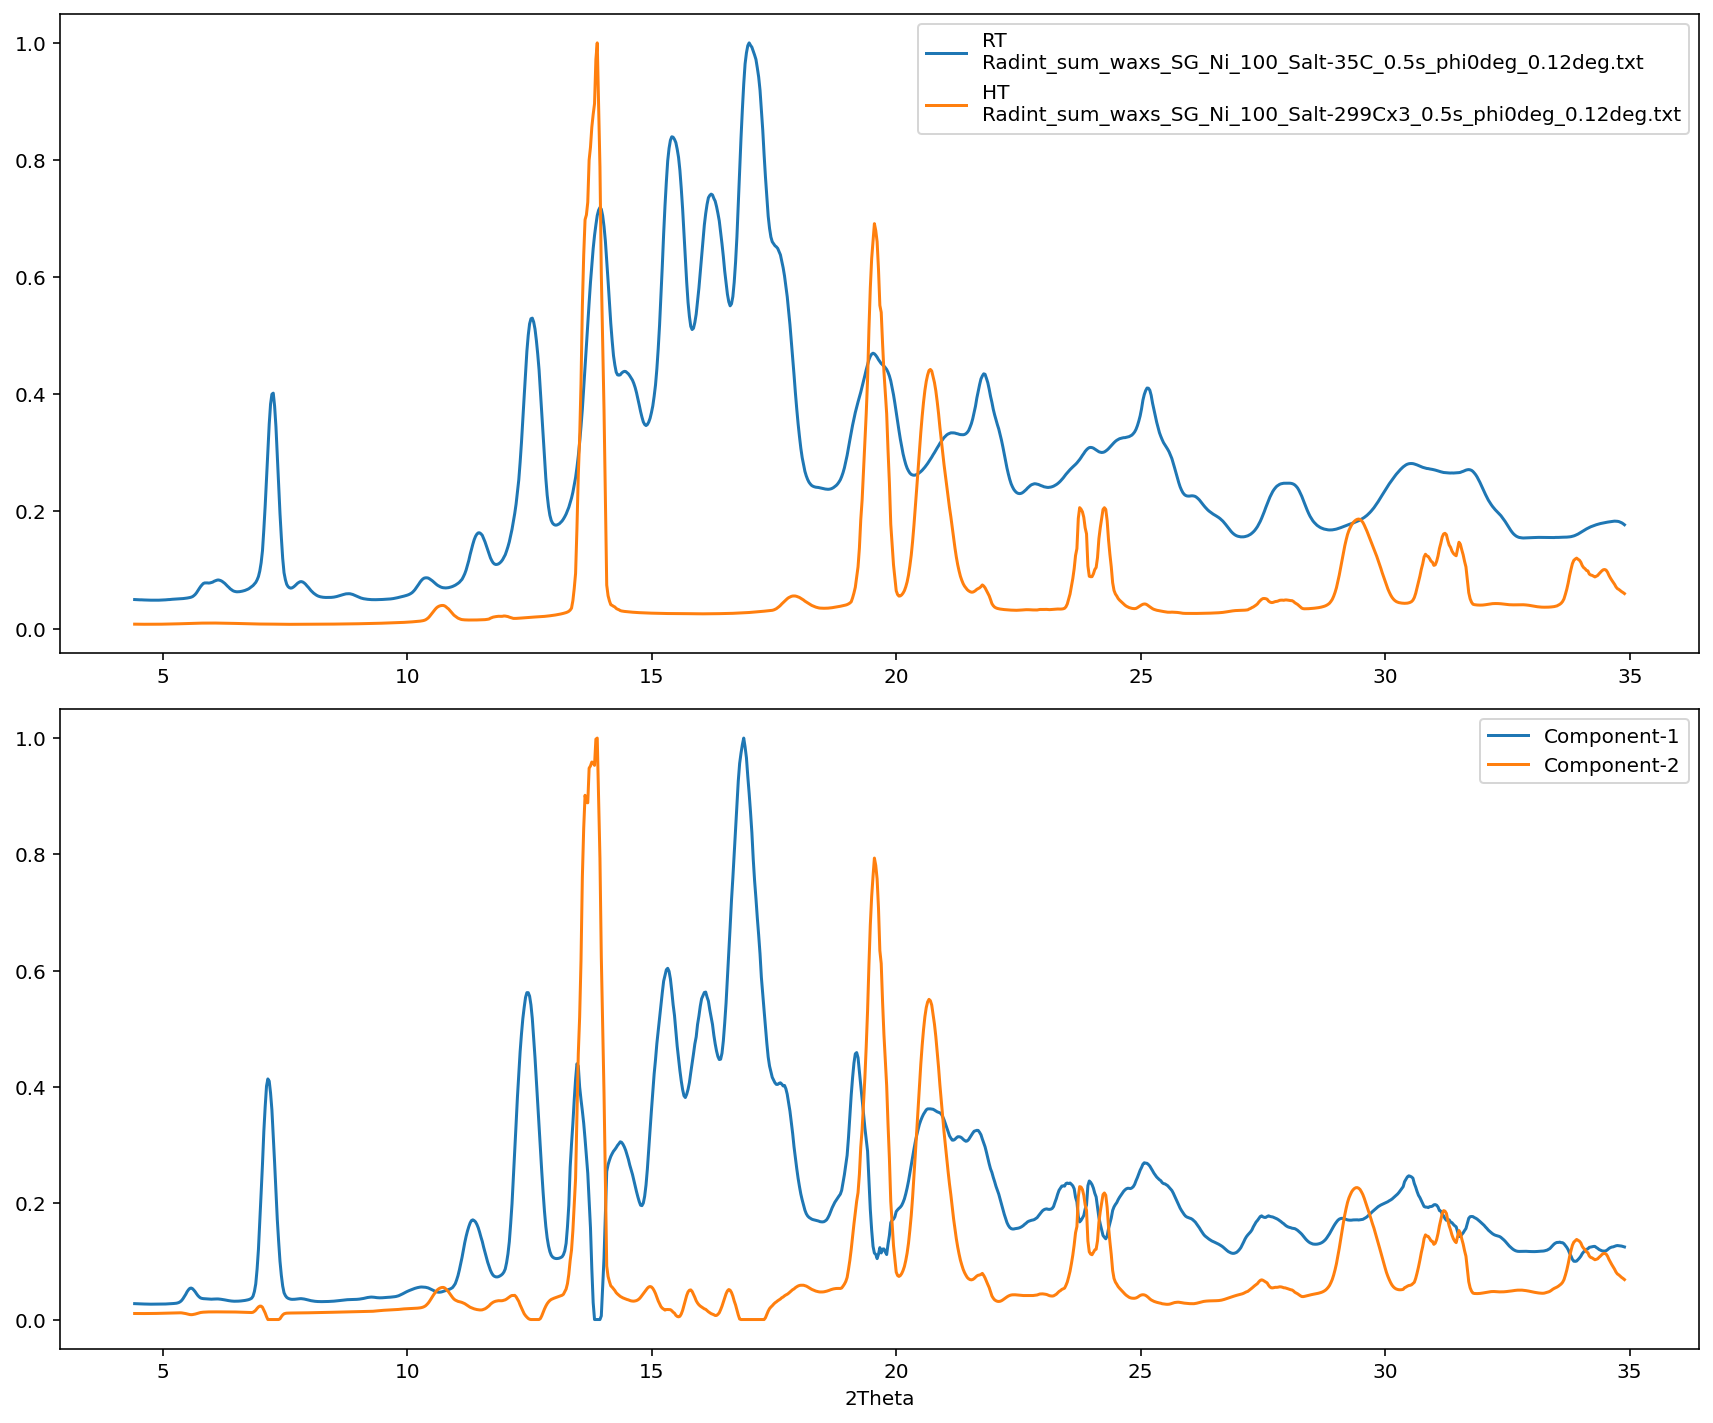

In [6]:
C1  = np.loadtxt('/Users/mtopsakal/gd_msee/mehmet_analysis/MCR-ALS/phi0_als_2comp_c1.xy',unpack=True)
C2  = np.loadtxt('/Users/mtopsakal/gd_msee/mehmet_analysis/MCR-ALS/phi0_als_2comp_c2.xy',unpack=True)


RTq  = np.loadtxt('/Users/mtopsakal/gd_msee/mehmet_analysis/MCR-ALS/Ni100/35/phi0/Radint_sum_waxs_SG_Ni_100_Salt-35C_0.5s_phi0deg_0.12deg.txt',unpack=True)
HTq  = np.loadtxt('/Users/mtopsakal/gd_msee/mehmet_analysis/MCR-ALS/Ni100/3rd-cool/phi0/Radint_sum_waxs_SG_Ni_100_Salt-299Cx3_0.5s_phi0deg_0.12deg.txt',unpack=True)

qrange = [160,1250]
pre_factor = 0.77 / (4 * np.pi)
RT = [np.rad2deg( 2 * np.arcsin( RTq[0][qrange[0]:qrange[1]] * pre_factor) ), RTq[2][qrange[0]:qrange[1]]]  
HT = [np.rad2deg( 2 * np.arcsin( HTq[0][qrange[0]:qrange[1]] * pre_factor) ), HTq[2][qrange[0]:qrange[1]]]  


fig = plt.figure(figsize=(12,10))

ax = fig.add_subplot(2,1,1)
ax.plot(RT[0],RT[1]/max(RT[1]),label='RT\nRadint_sum_waxs_SG_Ni_100_Salt-35C_0.5s_phi0deg_0.12deg.txt')
ax.plot(HT[0],HT[1]/max(HT[1]),label='HT\nRadint_sum_waxs_SG_Ni_100_Salt-299Cx3_0.5s_phi0deg_0.12deg.txt')
ax.legend()
out = np.column_stack((RT[0],RT[1]/max(RT[1])))
np.savetxt('from_match/RT.xy',out, fmt='%.5e',header='2Theta Intensity')
out = np.column_stack((HT[0],HT[1]/max(HT[1])))
np.savetxt('from_match/HT.xy',out, fmt='%.5e',header='2Theta Intensity')


ax = fig.add_subplot(2,1,2)
ax.plot(C1[0],C1[1],label='Component-1')
ax.plot(C2[0],C2[1],label='Component-2')
ax.legend()
ax.set_xlabel('2Theta')
out = np.column_stack((C1[0],C1[1]))
np.savetxt('from_match/comp1.xy',out, fmt='%.5e',header='2Theta Intensity')
out = np.column_stack((C2[0],C2[1]))
np.savetxt('from_match/comp2.xy',out, fmt='%.5e',header='2Theta Intensity')


plt.tight_layout()

In [7]:
os.chdir('from_match')

In [8]:
import sys
sys.path += ['/Users/mtopsakal/software/gsas2full/GSASII']
import GSASIIscriptable as G2sc


f=open('gsas.instprm',"w+")    
f.write("""#GSAS-II instrument parameter file for 0.7A wl
Type:PXC
Bank:1.0
Lam:0.77
Zero:0.0
Polariz.:0.99
Azimuth:0.0
U:5.9840407759
V:-1.28771353531
W:0.118521878603
X:-0.0977791308891
Y:4.40147397286
Z:0.0
SH/L:0.0264356231583
""")
f.close()

  
gpx    = G2sc.G2Project(newgpx='gsas.gpx')
gpx.add_powder_histogram('HT.xy',
                         'gsas.instprm')
hist   = gpx.histograms()[0]
gpx.add_phase('Entry_04-015-1665-KCl-clean.cif',phasename="KCl", histograms=[hist],fmthint='CIF')
phases = gpx.phases()

# Step 3: Set the scale factor to adjust the y scale
hist.SampleParameters['Scale'][0] = 1

gpx.data['Controls']['data']['max cyc'] = 0 # refinement not needed
gpx.do_refinements([{}])
x = gpx.histogram(0).getdata('x')
y = gpx.histogram(0).getdata('ycalc')

GSAS-II binary directory: /Users/mtopsakal/software/gsas2full/GSASII/bindist
8 values read from config file /Users/mtopsakal/software/gsas2full/GSASII/config.py
/Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components/from_match/HT.xy read by Reader comma/tab/semicolon separated
Instrument parameters read: /Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components/from_match/gsas.instprm (G2 fmt) bank None
/Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components/from_match/Entry_04-015-1665-KCl-clean.cif read by Reader CIF
gpx file saved as /Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components/from_match/gsas.gpx
gpx file saved as /Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_matching/PCA-components/from_match/gsas.gpx
Multiprocessing with 8 cores enabled
 Hessian Levenberg-Marquardt SVD refinement on 1 variables:
Found 0 SVD zeros
Read from file:/Users/mtopsakal/gd_msee/mehmet_analysis/SMI/pattern_

(5.0, 35.0)

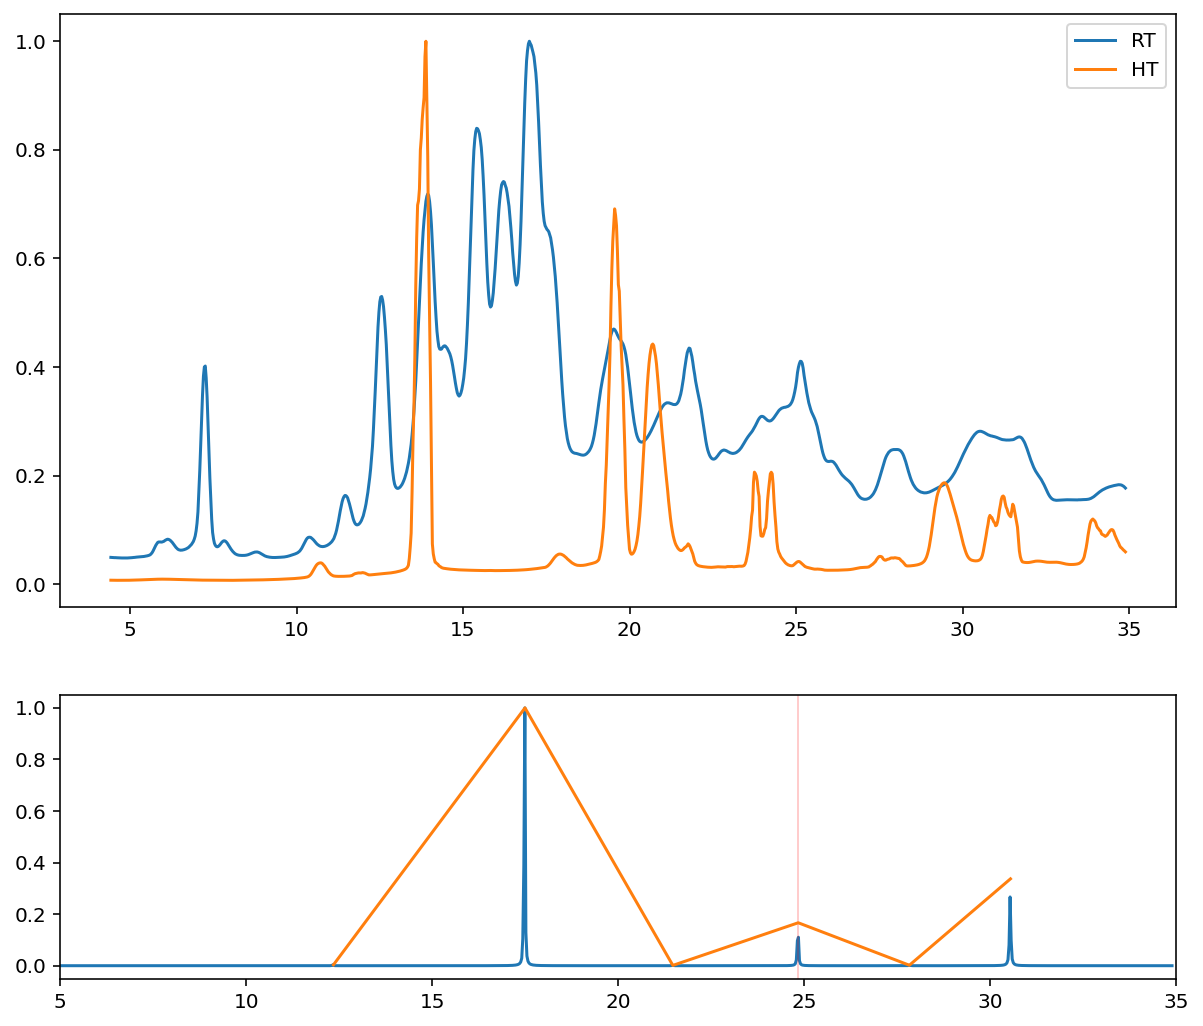

In [9]:
fig = plt.figure(figsize=(10,12))

ax = fig.add_subplot('211')
ax.plot(RT[0],RT[1]/max(RT[1]),label='RT')
ax.plot(HT[0],HT[1]/max(HT[1]),label='HT')
ax.legend()

ax = fig.add_subplot('413')
ax.plot(x,y/max(y))

refs0 = gpx[list(gpx.keys())[6]]['Reflection Lists'][phases[0].name]['RefList']
pos0 = [i[5] for i in refs0]
pos = [np.array(pos0)]
# ys = 0
# for e,p in enumerate(pos):
#     ax.plot(p, ys+p*0,'|',ms=10,color='k',label=phases[e].name)
#     ys = ys - 1
#     for l in p:
#         ax.axvline(x=l,linewidth=0.2,color='r')
ax.set_xlim([5,35])
        
        
import pymatgen as mg
structure = mg.Structure.from_file('Entry_04-015-1665-KCl-clean.cif')
from pymatgen.analysis.diffraction.xrd import XRDCalculator
d = XRDCalculator(wavelength=0.77)
ps = d.get_pattern(structure, scaled=True, two_theta_range=(5, 35))


ax.axvline(x=ps.x[3],linewidth=0.2,color='r')

ax.plot(ps.x,ps.y/100)
ax.set_xlim([5,35])

In [12]:
ls

CeO2.xy                               RT.mtd
Entry_00-025-1156-MgCl2.cif           RT.xy
Entry_00-037-1408.cif                 SiC.xy
Entry_00-045-1261-K3Mg2Cl7-hydro.cif  comp1.xy
Entry_01-078-3956-MgOH2.cif           comp2.xy
Entry_01-085-5633-MgO.cif             gsas.bak0.gpx
Entry_04-007-3218-NiCl2.cif           gsas.bak1.gpx
Entry_04-013-9448-K2MgCl4.cif         gsas.gpx
Entry_04-015-1665-KCl-clean.cif       gsas.instprm
Entry_04-015-1665-KCl.cif             gsas.lst
Entry_04-016-4592-Ni.cif              gsas.png
HT.xy                                 manual_matching/
LaB6.xy
